In [12]:

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [13]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [16]:
# reflect an existing database into a new model show tables
inspector = inspect(engine)

tables = inspector.get_table_names()
tables
# reflect the tables
for table in tables:
    columns = inspector.get_columns(table)
    print(table)
    print()
    for column in columns:
        print(column["name"], column["type"])
     
    display(pd.DataFrame(columns))
    
    print()

measurement

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,date,TEXT,True,None,auto,0
3,prcp,FLOAT,True,None,auto,0
4,tobs,FLOAT,True,None,auto,0



station

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


,name,type,nullable,default,autoincrement,primary_key
0,id,INTEGER,False,None,auto,1
1,station,TEXT,True,None,auto,0
2,name,TEXT,True,None,auto,0
3,latitude,FLOAT,True,None,auto,0
4,longitude,FLOAT,True,None,auto,0
5,elevation,FLOAT,True,None,auto,0


In [17]:
# View all of the classes that automap found
query = """
        SELECT
            *
        FROM
            station
        LIMIT 10;
    """
pd.read_sql(query, conn)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [18]:
query = """
        SELECT
            *
        FROM
            measurement
        LIMIT 10;
    """
pd.read_sql(query, conn)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
5,6,USC00519397,2010-01-07,0.06,70.0
6,7,USC00519397,2010-01-08,0.00,64.0
7,8,USC00519397,2010-01-09,0.00,68.0
8,9,USC00519397,2010-01-10,0.00,73.0
9,10,USC00519397,2010-01-11,0.01,64.0


In [13]:
Base = automap_base()
Base.prepare(engine, reflect = True)

In [14]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
recentDate = session.query(func.max(measurement.date)).limit(1).all()
recentDate

[('2017-08-23',)]

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date

query ="""
        SELECT
            date,
            prcp
        FROM
            measurement
        WHERE
            date >= (
                    SELECT
                        cast(cast(substr(max(date),1, 4) as integer) - 1 as text) || substr(max(date),5) as max_date
                    FROM
                        measurement
                )
        ORDER BY
            date;
        """
# Save the query results as a Pandas DataFrame
df=pd.read_sql(query, conn)
df

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


In [18]:
df["date"] = pd.to_datetime(df["date"])

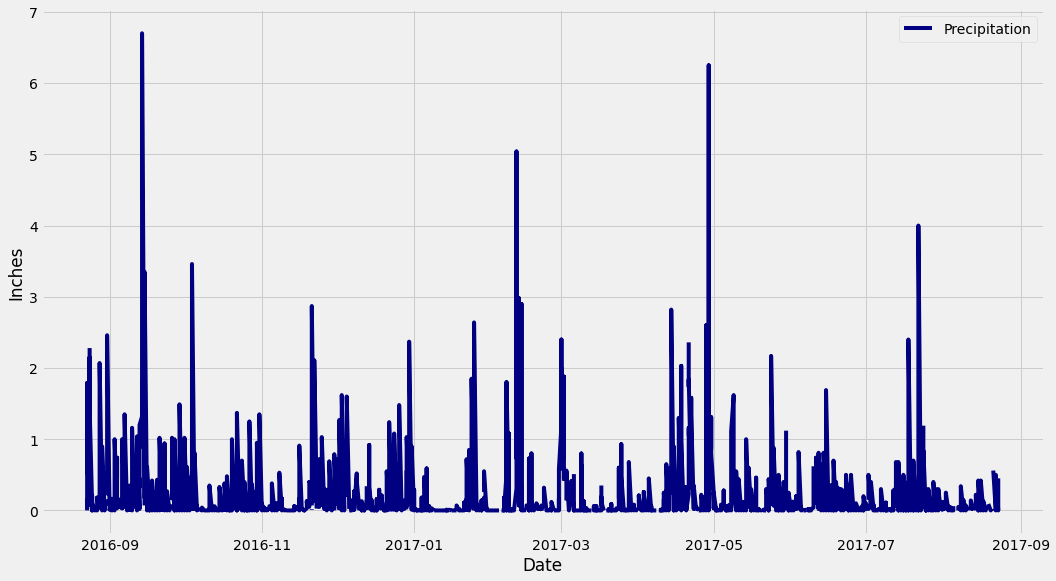

In [19]:

# Use Pandas Plotting with Matplotlib to plot the data
plt.subplots(figsize = (16,9))
plt.plot(df["date"], df["prcp"], color="navy", label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.show()



In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number stations in the dataset
countStation = session.query(func.count(station.station)).all()
countStation

[(9,)]

In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
query = """
        SELECT
            s.station,
            s.name,
            count(m.id) as activity
        FROM
            measurement m
            JOIN station s on m.station = s.station
        GROUP BY
            s.station,
            s.name
        ORDER BY
            activity desc;
        """

pd.read_sql(query, conn)

,station,name,activity
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [26]:

# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
query = """
        SELECT
            station,
            min(tobs) as LowestTemp,
            max(tobs) as HighestTemp,
            avg(tobs) as AvgTemp
        FROM
            measurement
        WHERE
            station = 'USC00519281';
        """

pd.read_sql(query, conn)

,station,LowestTemp,HighestTemp,AvgTemp
0,USC00519281,54.0,85.0,71.663781


In [25]:
query ="""
        SELECT
            date,
            prcp
        FROM
            measurement
        WHERE
            date >= (
                    SELECT
                        cast(cast(substr(max(date),1, 4) as integer) - 1 as text) || substr(max(date),5) as max_date
                    FROM
                        measurement
                ) and station = 'USC00519281'
        ORDER BY
            date
        Limit (1);
        """

df=pd.read_sql(query, conn)
df

,date,prcp
0,2016-08-23,1.79


In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
query = """
        SELECT
        station,
          date,
          tobs
        FROM
            measurement
        where
            date >= '2016-08-23'
        and station = 'USC00519281'
        order by
            date asc
        """

df2 = pd.read_sql(query, conn)
df2["date"] = pd.to_datetime(df2["date"])
df2


,station,date,tobs
0,USC00519281,2016-08-23,77.0
1,USC00519281,2016-08-24,77.0
2,USC00519281,2016-08-25,80.0
3,USC00519281,2016-08-26,80.0
4,USC00519281,2016-08-27,75.0
...,...,...,...
347,USC00519281,2017-08-14,77.0
348,USC00519281,2017-08-15,77.0
349,USC00519281,2017-08-16,76.0
350,USC00519281,2017-08-17,76.0


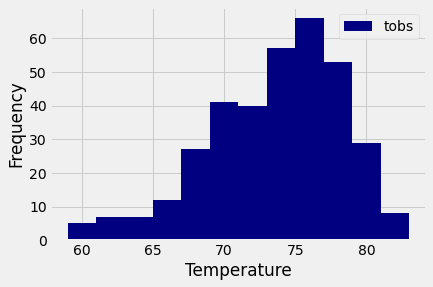

In [26]:
#plot the results as a histogram
plt.hist(df2.tobs, bins=12, color='navy', label = 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close session

In [27]:
# Close Session
session.close()